## Pong from Pixels
personal notes for andrej kaparthy's http://karpathy.github.io/2016/05/31/rl/ post

1. Recieve image frame (`210x160x3`).
2. Decide if we want to move up UP or DOWN.
3. After ever choice we get a reward ( +1 if we score, -1 if the opponent scores, 0 otherwise )
4. Gloal is to move the paddle so we get lots of reward

## Policy network
- implements our player (agent in AI speak)
- takes the state of the game and decides what to do

### first implementation: 2-layer neural network
- input = state of the game = 100,800 raw pixels.
- output = single number = probability of going UP.
- it is standard to use a stochastic polichy (we only produce the probability of moving up).
- on every iteration we will sample from our output distribution to get the actual move)

![image](policy.png)


### Policy Network in Numpy
Given a vector `x` that holds preprocessed pixel information.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

### I'll start with a random image for now since I can't get gym to work
- no biases for now, 4 hidden layers

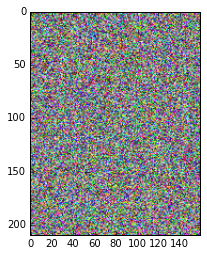

In [2]:
x = np.random.randint(low=1, high=255, size=100800)
plt.imshow(x.reshape(210, 160, 3))
plt.show()

In [3]:
h_layers = 4
W1 = np.random.rand(100800, h_layers).T # random weights, same shape as input image
W2 = np.random.rand(4)


h = np.dot(W1, x) # compute hidden layer neuron activations
h[h<0] = 0 # ReLU nonlinearity: threshold at zero
logp = np.dot(W2, h) # compute log probability of going up
p = 1.0 / (1.0 + np.exp(-logp)) # sigmoid function (gives probability of going up)

The neurons in the hidden layer (`W1` weights) can detect various game scenarios ( ball is in the top, paddle in the middle ), and the weights in `W2` can decide if in each case we sould go UP or DOWN. The random initial weights will cause the player to spasm on the spot. We now need to have to adjust `W1` and `W2` that will lead to expert pong play.

### Credit Assignment Problem
In pong, an action wont pay off immediately. We may be rewarded 20 frames later when the ball passes our opponent so how do we know which action should be rewarded. The solution to this policy gradients

### Basic supervised learning
![image](http://karpathy.github.io/assets/rl/sl.png)

### Policy gradients, because we don't have clear labels like in supervised learning
1. calculate logprob of going UP and DOWN (1 - UP).
2. Sample an action from this distribution and execute it in game. (this is similar to text generation).
3. At this point we have a gradient for down and we could evaluate that gradient to figure out which weights will make our model more likely to predict down given that image the same as we do for supervised learning. But we don't know if down is good or not. This is ok because we can just wait a bit and see. In pong we could wait until the end of the game.

![img](http://karpathy.github.io/assets/rl/rl.png)

## Training Protocol
1. Initialize some `W1` and `W2`.
2. Play 100 games of Pong (policy "rollouts"):
    - each game = 200 frames.
    - 20,000 decisions for going UP or DOWN.
    - for each decision we know the parameter gradient (tells us how we should change params to encourage that decision in that state int he future.
3. we now have to label each decision we've made as good or bad:
    - if we won 12 games and lost 88 we take all 200*12 = 2400 decisions we made in the winning games and do a positive update (fill +1.0 in the gradient for the sampled action, backprop and update params encouraging those actions). then take all 200*88 = 17600 decisions we made in the losing games and do a negative update (discouraging whatever we did).
    - the network will now become slightly more likely to repeat actions that worked and slightly less likely to repeat actions that didn't work.
4. repeat

![img](http://karpathy.github.io/assets/rl/episodes.png)


## Script

In [4]:
import cPickle as pickle
import gym

### Set hyper-params

In [5]:
H = 200 # number of hidden layer neurons
batch_size = 10 # how many episodes to do a param update
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = True # resume from previous checkpoint?
render = False

### Model initialization

In [6]:
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
    model = pickle.load(open('save.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H,D) / np.sqrt(D) # Xavier init
    model['W2'] = np.random.randn(H) / np.sqrt(H)

# setup for rmsprop

# update buffers that add up gradients over a batch
grad_buffer = { k : np.zeros_like(v) for k,v in model.iteritems() }
# rmsprop memory
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.iteritems() } 

### policy network functions

In [7]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
    """
    preprocess 210x160x3 uint8 frame into 6400 (80x80) 1D float vector
    """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by a factor of 2
    I[I == 144] = 0 # erase background (bg type 1)
    I[I == 109] = 0 # erase background (bg type 2)
    I[I != 0] = 1 # set everything else (ball, paddles) to 1
    return I.astype(np.float).ravel()

def discount_rewards(r):
    """
    Take 1D float of array of rewards and compute discounted reward
    """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific)
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h<0] = 0 # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
    """
    backward pass. (eph is array of intermediate hidden states)
    """
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0 # backprop through relu
    dW1 = np.dot(dh.T, epx)
    return {'W1': dW1, 'W2':dW2}

### env_parms

In [ ]:
env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs, hs, dlogps, drs = [], [], [], []
running_reward = None
reward_sum = 0
episode_number = 0

[2016-09-23 22:17:27,387] Making new env: Pong-v0


### Run

In [ ]:
while True:
    if render: env.render()
        
    # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x
    
    # forward the policy network and sample an action from the returned probability
    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3 # roll the dice!
    
    # record various intermediates (needed later for backprop)
    xs.append(x) # observation
    hs.append(h) # hidden state
    y = 1 if action == 2 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken
    
    # step the environment and gget new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward
    
    drs.append(reward) 
    # record reward (has to be done after we call step() to get reward for previous action)
    
    if done: # an episode finished
        episode_number += 1
        
        # stack together all inputs, hidden stats, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs,hs,dlogps,drs = [],[],[],[] # reset array memory
        
        # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
        # standardize the rewards to be unit normal (controls the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)
        
        epdlogp *= discounted_epr # modulate the gradient with advantage
        grad = policy_backward(eph, epdlogp)
        for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch
            
        # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k,v in model.iteritems():
                g = grad_buffer[k] # gradient
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer
                
        # book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print 'resetting env. episode reward total was %f. running mean: %f' % (reward_sum, running_reward)
        if episode_number % 100 == 0: pickle.dump(model, open('save.p', 'wb'))
        reward_sum = 0
        observation = env.reset()
        prev_x = None
        
    if reward != 0: # pong has either +1 or -1 reward exactly when game ends
        print ('ep %d: game finished, reward: %f' % (episode_number, reward)) + ('' if reward == -1 else ' !!!!!!!!')

ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: -1.000000
ep 0: game finished, reward: 1.000000 !!!!!!!!
resetting env. episode reward total was -20.000000. running mean: -20.000000
ep 1: game finished, reward: -1.000000
ep 1: game finished, reward: -1.000000
ep 1: game finishe

In [ ]:
plt.imshow(env.reset())
plt.show()